# Process and "slim down" CLIWOC 2.1

Original data downloaded courtesy of Historical Climatology:

> [`https://www.historicalclimatology.com/cliwoc.html#`](https://www.historicalclimatology.com/cliwoc.html#)

In [1]:
%matplotlib inline

import pandas
import geopandas
import contextily as cx
from shapely.geometry import LineString, MultiLineString

Variable names and explanations are available at:

> [`https://stvno.github.io/page/cliwoc/`](https://stvno.github.io/page/cliwoc/)

We will keep only those relating to the date, (clean) location, ID and country:

In [2]:
tokeep = [
    "YR",
    "MO",
    "DY",
    "HR",
    "latitude",
    "longitude",
    "ID",
    "C1",
]

First let's read the data:

In [3]:
%time db = geopandas.read_file("cliwoc21.gpkg")

CPU times: user 1min 10s, sys: 3.52 s, total: 1min 13s
Wall time: 1min 13s


Then we want to do perform the following operations:

- Drop variables we don't need

In [4]:
slim = db[tokeep + ["geometry"]]
slim.shape

(282322, 9)

- Remove logs with a single occurrence of `ID` and with missing lon/lat

In [5]:
missing = db[["longitude", "latitude"]].dropna().index
slim = slim.reindex(missing)

ocs = slim.groupby("ID")\
          .size()
slim = slim[slim["ID"].isin(ocs[ocs > 1].index)]

- Add date column

In [6]:
slim["date"] = slim["YR"].astype(str) + "-" + \
               slim["MO"].astype(str) + "-" + \
               slim["DY"].astype(str) + " "

- Create column with days since first record

In [7]:
%%time
timefy = lambda d: pandas.Period(d, freq="D")
slim["dys_since_start"] = slim["date"].apply(timefy)
slim["dys_since_start"] = (slim["dys_since_start"] - \
                           slim["dys_since_start"].min()\
                          ).apply(lambda d: d.n)

CPU times: user 1min 1s, sys: 111 ms, total: 1min 1s
Wall time: 1min 1s


* Write out to a `geopackage`

In [8]:
! rm cliwoc_slim.geopackage
%time slim.to_file("cliwoc_slim.geopackage", driver="GPKG")

CPU times: user 46.5 s, sys: 1.43 s, total: 47.9 s
Wall time: 47.9 s


* Write out to a `GeoJSON` to create the tileset

In [9]:
! rm cliwoc_slim.geojson
%time slim.to_file("cliwoc_slim.geojson", driver="GeoJSON")

rm: cannot remove 'cliwoc_slim.geojson': No such file or directory
CPU times: user 46.6 s, sys: 432 ms, total: 47 s
Wall time: 47 s


* Turn into vector tiles with [`tippecanoe`](https://github.com/mapbox/tippecanoe) (install required)

In [10]:
%%time
! rm -f cliwoc_slim.mbtiles
! /home/jovyan/tippecanoe/tippecanoe -zg \
             -o cliwoc_slim.mbtiles \
             --drop-densest-as-needed \
             cliwoc_slim.geojson
! rm cliwoc_slim.geojson

For layer 0, using name "cliwoc_slim"
260631 features, 17440167 bytes of geometry, 8 bytes of separate metadata, 910885 bytes of string pool
Choosing a maxzoom of -z3 for features about 46766 feet (14255 meters) apart
tile 1/0/0 size is 644977 with detail 12, >500000    
Going to try keeping the sparsest 69.77% of the features to make it fit
tile 2/1/2 size is 503513 with detail 12, >500000    
Going to try keeping the sparsest 89.37% of the features to make it fit
tile 2/2/2 size is 587722 with detail 12, >500000    
Going to try keeping the sparsest 76.57% of the features to make it fit
tile 2/1/1 size is 1404101 with detail 12, >500000    
Going to try keeping the sparsest 32.05% of the features to make it fit
tile 2/1/1 size is 519948 with detail 12, >500000    
Going to try keeping the sparsest 27.74% of the features to make it fit
tile 3/5/4 size is 584387 with detail 12, >500000    
Going to try keeping the sparsest 77.00% of the features to make it fit
tile 3/2/3 size is 684024

## Routes

Here we build ship "routes" by groupby logs by `ID`, sorting them chronologically, and linking them in a `LineString`.

In [11]:
%%time

def routify(g):
    ordered = g.sort_values(["YR", "MO", "DY"])
    start = ordered.iloc[0, :][["YR", "MO", "DY"]]
    end = ordered.iloc[-1, :][["YR", "MO", "DY"]]
    diffs = ordered["longitude"].diff(1).abs()
    if diffs.max() > 170:
        # Find cutoff point
        cutoff = diffs[diffs == diffs.max()].index[0]
        post = ordered.loc[cutoff:, :]
        pre = ordered.loc[ordered.index.difference(post.index), :]\
                     .sort_values(["YR", "MO", "DY"])
        # Split line
        line = MultiLineString([LineString(pre.geometry.tolist()),
                                LineString(post.geometry.tolist())
                               ])
    else:
        line = LineString(ordered.geometry.tolist())
    route = {"geometry": line,
             "start": "-".join(start.astype(str).tolist()),
             "end": "-".join(end.astype(str).tolist()),
             "records": g.shape[0],
             "C1": g["C1"].iloc[0],
             "length_days": ordered["dys_since_start"].max() - \
                            ordered["dys_since_start"].min()
            }
    return route

routes = slim.groupby("ID")\
             .apply(routify)
routes = geopandas.GeoDataFrame(routes.tolist(),
                                crs=slim.crs,
                                index=routes.index
                               )

CPU times: user 18.2 s, sys: 228 ms, total: 18.4 s
Wall time: 18.4 s


/opt/conda/lib/python3.7/site-packages/contextily/tile.py:509: RuntimeWarning: divide by zero encountered in log2
  zoom_lon = np.ceil(np.log2(360 * 2.0 / lon_length))


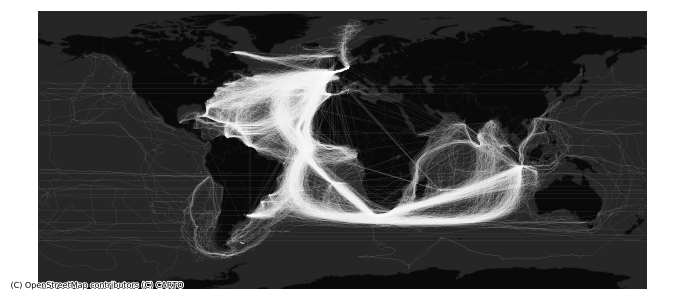

In [18]:
ax = routes.plot(linewidth=0.1, 
                 color="white",
                 alpha=0.5,
                 figsize=((12, 12))
                )
cx.add_basemap(ax,
               crs=routes.crs.to_string(), 
               url=cx.providers.CartoDB.DarkMatterNoLabels
              )
ax.set_axis_off()

* Write out to a `geopackage`

In [14]:
! rm cliwoc_routes.geopackage
%time routes.to_file("cliwoc_routes.geopackage", driver="GPKG")

CPU times: user 641 ms, sys: 16 ms, total: 657 ms
Wall time: 654 ms


* Write out to a `GeoJSON` to create the tileset

In [15]:
! rm cliwoc_routes.geojson
%time routes.to_file("cliwoc_routes.geojson", driver="GeoJSON")

CPU times: user 1.86 s, sys: 24 ms, total: 1.89 s
Wall time: 1.89 s


* Turn into vector tiles with [`tippecanoe`](https://github.com/mapbox/tippecanoe) (install required)

In [16]:
%%time
! rm -f cliwoc_routes.mbtiles
! /home/jovyan/tippecanoe/tippecanoe -zg \
             -o cliwoc_routes.mbtiles \
             --drop-densest-as-needed \
             cliwoc_routes.geojson
! rm cliwoc_routes.geojson

For layer 0, using name "cliwoc_routes"
1973 features, 2328398 bytes of geometry, 42197 bytes of separate metadata, 49204 bytes of string pool
Choosing a maxzoom of -z0 for features about 264262 feet (80547 meters) apart
  99.9%  0/0/0  
CPU times: user 85.2 ms, sys: 460 ms, total: 545 ms
Wall time: 2.78 s


## Zip

In [17]:
! rm cliwoc_slim_routes.zip
! zip cliwoc_slim_routes.zip cliwoc_routes.* cliwoc_slim.* README.md

  adding: cliwoc_routes.geopackage (deflated 71%)
  adding: cliwoc_routes.mbtiles (deflated 5%)
  adding: cliwoc_slim.geopackage (deflated 65%)
  adding: cliwoc_slim.mbtiles (deflated 1%)
  adding: README.md (deflated 55%)
